Import libraries


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms,models
import torchvision
from torchvision.utils import save_image
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import numpy as np
from imblearn.over_sampling import SMOTE
import os

In [2]:
all_models = torchvision.models.list_models()
classification_models = torchvision.models.list_models(module=torchvision.models)
# print(f"all models: \n {all_models}")
print(f"classif models: \n {classification_models}")

classif models: 
 ['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_

In [3]:
# ResNet & DenseNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# EfficientNet_b1
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(240),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# RegNet
# transform = transforms.Compose([
#     transforms.Resize(232),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# ConvNext
# transform = transforms.Compose([
#     transforms.Resize(236),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [4]:
df = pd.read_csv("data/train_classes.csv")
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


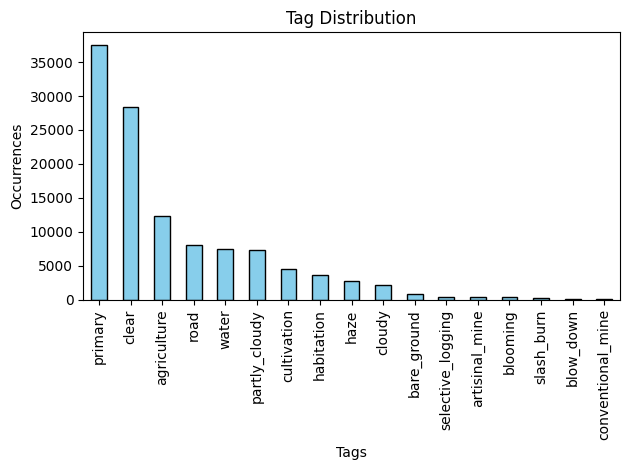

In [5]:
all_labels = df['tags'].str.split(expand=True).stack()

# Count occurrences of each label
label_counts = all_labels.value_counts()

# Plot the distribution
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Tag Distribution')
plt.xlabel('Tags')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)

In [7]:
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


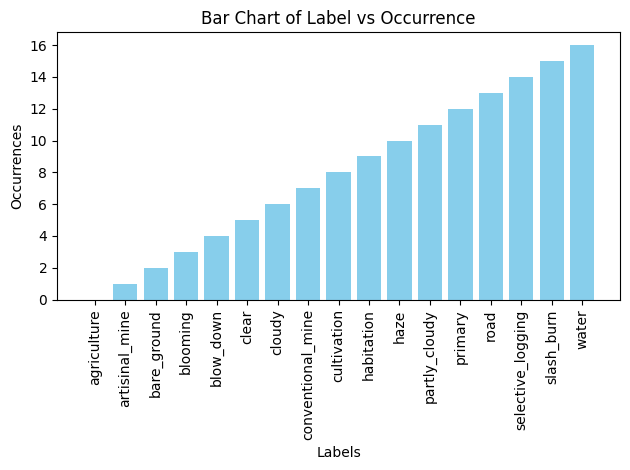

In [8]:
# Extract labels and values
labels = list(tag_to_idx.keys())
values = list(tag_to_idx.values())

# Plotting the bar chart
plt.bar(labels, values, color='skyblue')  # You can customize the color
plt.xlabel('Labels')
plt.ylabel('Occurrences')
plt.title('Bar Chart of Label vs Occurrence')
plt.xticks(rotation=90)  # Rotate labels if they are long
plt.tight_layout()  # Adjust layout to avoid overlap

# Show the plot
plt.show()

### DATA PREPROCEESING

In [9]:
# Split the 'tags' column into lists of individual labels
df['tags'] = df['tags'].apply(lambda x: x.split())

# Binarize the tags (one-hot encode the labels)
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df['tags'])

# Add the binary labels to the DataFrame
df = df.drop(columns=['tags'])  # Drop the original 'tags' column
for idx, label in enumerate(mlb.classes_):
    df[label] = binary_labels[:, idx]

# Save the label mapping for future use
tag_to_idx = {tag: idx for idx, tag in enumerate(mlb.classes_)}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

# Save the preprocessed DataFrame
df.to_csv('preprocessed_train_classes.csv', index=False)

Combine the numerical features and labels

In [55]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        

        if self.transform:
            image = self.transform(image)
        self.df.iloc[:, 1:] = self.df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
        # Extract labels as a tensor
        labels = torch.tensor(self.df.iloc[idx, 1:].values.astype(np.float32))
        return image, labels

In [27]:
def extract_features(dataset, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove final layer
    model.eval()

    features = []
    labels = []


    with torch.no_grad():
        for images, lbls in dataloader:
            output = model(images)
            features.append(output.squeeze().cpu().numpy())
            labels.append(lbls.cpu().numpy())

    return np.vstack(features), np.vstack(labels)

In [57]:
dataset = MultiLabelImageDataset(csv_file="preprocessed_train_classes.csv", img_dir="data/train-jpg", transform=transform)

In [ ]:
# get features and labels
features, labels = extract_features(dataset)

e:\cv\giit\cv-1d-project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\cv\giit\cv-1d-project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
# perform smote
def ml_smote(features, labels, k=5):
    """
    Multilabel SMOTE implementation.

    :param features: Feature matrix
    :param labels: Multilabel binary matrix
    :param k: Number of nearest neighbors
    :return: Synthetic features and labels
    """
    synthetic_features = []
    synthetic_labels = []

    # Find minority label instances
    minority_indices = np.where(labels.sum(axis=1) < labels.shape[1] // 2)[0]
    minority_features = features[minority_indices]
    minority_labels = labels[minority_indices]

    # Nearest neighbors
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(minority_features)
    
    for i in range(len(minority_features)):
        neighbors = nn.kneighbors([minority_features[i]], return_distance=False).flatten()
        for neighbor in neighbors[1:]:
            # Interpolate features
            diff = minority_features[neighbor] - minority_features[i]
            synthetic_feature = minority_features[i] + np.random.rand() * diff
            synthetic_features.append(synthetic_feature)
            
            # Combine labels
            synthetic_label = np.logical_or(minority_labels[i], minority_labels[neighbor]).astype(int)
            synthetic_labels.append(synthetic_label)
    
    return np.vstack(synthetic_features), np.vstack(synthetic_labels)

# PERFORM ML SMOTE

In [ ]:
synthetic_features, synthetic_labels = ml_smote(features, labels)

# load in the smoted dataset
if doesnt exist, skip the next code block

In [ ]:
# if everything ran already, just import the csv
final_features = pd.read_csv("output.csv")
final_labels = pd.read_csv("smote_train_labels.csv")

In [71]:
# convert the csv features to 0 and 1
all_tags = set()
for tags in final_labels['Labels'].str.split():
    all_tags.update(tags)
final_labels['Labels'] = final_labels['Labels'].apply(lambda x: x.split())

mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(final_labels['Labels'])

# Add the binary labels to the DataFrame
csv_synthetic_labels = final_labels.drop(columns=['Labels'])  # Drop the original 'tags' column
for idx, label in enumerate(mlb.classes_):
    csv_synthetic_labels[label] = binary_labels[:, idx]

# Save the label mapping for future use
tag_to_idx = {tag: idx for idx, tag in enumerate(mlb.classes_)}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

Integrate the dataset

In [ ]:
# Convert gpu tensor into numpy
labels_np = labels.cpu().numpy()

# Combine original and synthetic data
final_features = np.concatenate((features, synthetic_features),axis=0)
final_labels = np.concatenate((labels_np, synthetic_labels),axis= 0)


print(final_features[0])


In [ ]:
import numpy as np
from PIL import Image
import os

# Assuming 'features' is your array of features
def save_feature_as_image(features, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, feature_vector in enumerate(features):
        # Reshape the feature vector into a square 2D matrix (e.g., 64x64)
        side_length = int(np.sqrt(len(feature_vector)))  # Assuming it's a perfect square
        reshaped_image = feature_vector[:side_length * side_length].reshape((side_length, side_length))
        
        # Normalize to [0, 255] range for saving as image
        reshaped_image = (reshaped_image - reshaped_image.min()) / (reshaped_image.max() - reshaped_image.min()) * 255
        reshaped_image = reshaped_image.astype(np.uint8)

        # Convert to image and save as JPG
        img = Image.fromarray(reshaped_image)
        img.save(os.path.join(output_dir, f"train_{i}.jpg"))

# Example usage
save_feature_as_image(final_features, 'smote_images')


In [ ]:
# Function to convert feature vectors into images
def visualize_feature_as_image(features, num_images=5, image_size=(256, 256)):
    """
    Convert feature vectors into image-like structures and visualize them.
    
    :param features: The feature matrix (e.g., from ResNet)
    :param num_images: Number of images to visualize
    :param image_size: The size to reshape each feature vector into (e.g., 64x64)
    """
    for i in range(min(num_images, features.shape[0])):
        feature_vector = features[i]
        
        # Reshape feature vector to an image-like structure (for visualization)
        feature_image = feature_vector.reshape(image_size)  # Assuming square-shaped images
        
        # Normalize the image to the range [0, 1] for visualization
        feature_image = (feature_image - feature_image.min()) / (feature_image.max() - feature_image.min())
        
        # Convert to image format for visualization
        feature_image = Image.fromarray((feature_image * 255).astype(np.uint8))
        
        plt.figure(figsize=(3, 3))
        plt.imshow(feature_image, cmap='gray')
        plt.axis('off')
        plt.show()

# NOTE: these are not how the images will look like, they are just feature vectors
visualize_feature_as_image(synthetic_features, num_images=2, image_size=(32, 64))

In [ ]:
# convert one hot vector back to original
original_labels = ["agriculture", "artisinal_mine", "bare_ground", "blooming", "blow_down", "clear", "cloudy", "conventional_mine", "cultivation", "habitation", "haze", "partly_cloudy", "primary", "road", "selective_logging", "slash_burn", "water"]
def get_labels(one_hot_array, labels):
    result = []
    for vector in one_hot_array:
        # Find indices where the value is 1
        indices = np.where(vector == 1)[0]
        # Map those indices to the corresponding labels
        result.append([labels[i] for i in indices])
    return result

labels_mapped = get_labels(final_labels, original_labels)


In [ ]:
print(labels_mapped[0])

In [ ]:
import csv
# save the new labels into  file
# Prepare data for CSV
csv_data = []
for idx, label_list in enumerate(labels_mapped, start=1):
    # Join the labels for each row with commas (multi-label)
    csv_data.append([f"train_{idx}", " ".join(label_list)])

# Write data to CSV file
with open('smote_train_labels.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Index", "Labels"])  # Writing header
    writer.writerows(csv_data)  # Writing data

print("CSV file 'smote_train_labels.csv' saved successfully.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## CGAN


In [ ]:
# Convert MLSMOTE features and labels to tensors
ml_smote_features = torch.tensor(synthetic_features, dtype=torch.float32).to(device)
ml_smote_labels = torch.tensor(synthetic_labels, dtype=torch.float32).to(device)

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        input = torch.cat((noise, labels), dim=1)
        return self.model(input)

class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        input = torch.cat((img, labels), dim=1)
        return self.model(input)


In [ ]:
import torch.optim as optim

# Training parameters
noise_dim = 100
label_dim = len(mlb.classes_)
img_dim = features.shape[1]
lr = 0.0002
batch_size = 32
epochs = 100

generator = Generator(noise_dim, label_dim, img_dim)
discriminator = Discriminator(img_dim, label_dim)
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        
        # Real labels
        valid = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)
        
        # Train Discriminator
        print(real_imgs.shape)
        print(labels.shape)
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        real_loss = criterion(discriminator(real_imgs, labels), valid)

        noise = torch.randn(batch_size, noise_dim).to(device)
        gen_labels = torch.randint(0, 2, (batch_size, label_dim)).float().to(device)
        fake_imgs = generator(noise, gen_labels)
        fake_loss = criterion(discriminator(fake_imgs, gen_labels), fake)
        
        d_loss = (real_loss + fake_loss) / 2
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        fake_imgs = generator(noise, gen_labels)
        g_loss = criterion(discriminator(fake_imgs, gen_labels), valid)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")


SPLIT


In [ ]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Select the device to use dynamically

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
torch.cuda.is_available()

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [ ]:
import torchvision.models as models
from torch import nn

num_classes = 17

def ResNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.resnet50(weights='DEFAULT')
    num_ftrs = model_ft.fc.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def DenseNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.densenet121(weights='DEFAULT')
    num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    return model_ft

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

def RegNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.regnet_y_8gf(weights='DEFAULT')
    print(model_ft)
    num_ftrs = model_ft.fc.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def ConvNextClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.convnext_tiny(weights='DEFAULT')
    num_ftrs = model_ft.classifier[2].in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(num_ftrs, num_classes)
        )
    return model_ft

In [ ]:
# model = ResNetClassifier(num_classes)
# model = DenseNetClassifier(num_classes)
# model = EfficientNetClassifier(num_classes)
model = RegNetClassifier(num_classes)
# model = ConvNextClassifier(num_classes)

model.to(device)
model

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches
    
    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss


In [ ]:
print(device)

In [ ]:
learning_rate = 0.001
epochs = 5

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    f2, test_loss = test_loop(test_dataloader, model, loss_fn)
    all_loss.append(test_loss)
print("Done!")

In [ ]:
print(all_loss)

epochs_list = list(range(1, len(all_loss) + 1))
# print(len(all_loss))
# print(epochs)

plt.plot(epochs_list, all_loss, marker='o', color='b', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def predict_image(model, image_path, transform, idx_to_tag):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.sigmoid(outputs)
        predicted = probabilities > 0.24
        predicted_labels = [idx_to_tag[i] for i, pred in enumerate(predicted[0]) if pred]

    return predicted_labels, probabilities[0]

In [ ]:
image_path = "data/test-jpg/test_5689.jpg"
predicted_labels, probabilities = predict_image(model, image_path, transform, idx_to_tag)

print("Predicted labels:", predicted_labels)
print("Probabilities:")
for i, prob in enumerate(probabilities):
    if prob > 0.24:
        print(f"{idx_to_tag[i]}: {prob.item():.4f}")